# Temporal and Spatial DataMining
## Exercise_02_Preprocessing

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use('ggplot')

### Task 1: Missing values

**a)** Import the function "get_disturbed_signal" from the util package and plot the returned signal.

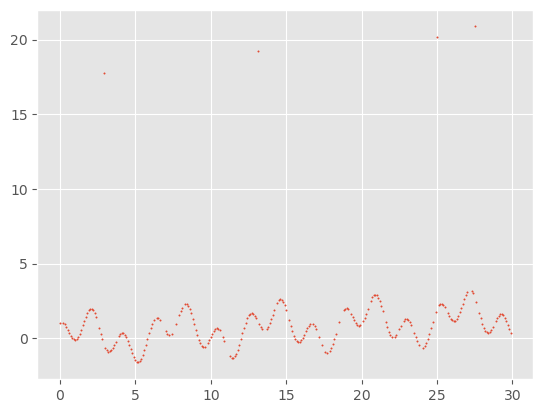

In [4]:
from util import get_disturbed_signal

x = get_disturbed_signal()  # returns tupel
plt.scatter(x[0], x[1], s=0.8)

**b)** Remove outliers and plot the signal.

**Note:** Think of NaN as well!

x    14.824706
y     1.069510
dtype: float64


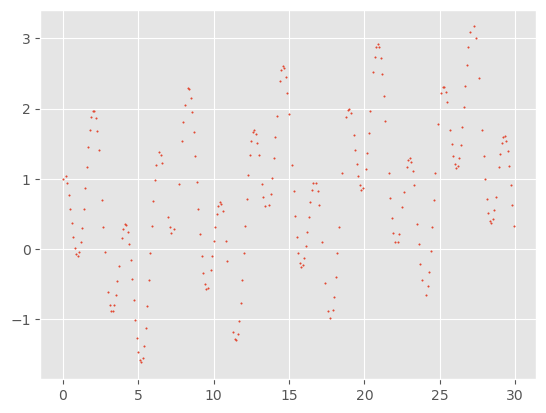

In [5]:
data = pd.DataFrame({'x': x[0], 'y': x[1]})
data.dropna(inplace=True)   # remove NaN values

# remove outliers: values that are more than 2 standard deviations away from the mean
# assumption: data is normally distributed
mu_col = data.mean()
std_col = data.std()
print(mu_col)
data = data[data['y'] <= mu_col['y'] + 2 * std_col['y']]
data = data[data['y'] >= mu_col['y'] - 2 * std_col['y']]  

plt.scatter(data['x'], data['y'], s=0.9)

**c)** Import the function "nan_helper" and replace the missing values by interpolation.
Plot the signal.

**Note:** https://stackoverflow.com/a/6520696

X Axis has NaN values:  False
Y Axis has NaN values:  True


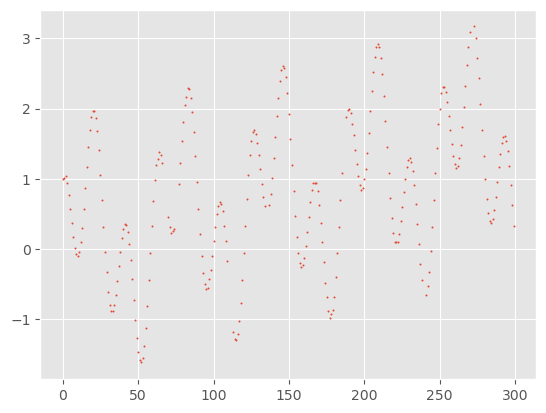

In [6]:
from util import nan_helper

non_nan = x[1]

# substitution of outlier with nan
# print('non NaN values:\n', non_nan[~nan_helper(non_nan)[0]])
mu = non_nan[~nan_helper(non_nan)[0]].mean()    # mean of non NaN values
std = non_nan[~nan_helper(non_nan)[0]].std()    # std of non NaN values
non_nan[non_nan > mu + 2 * std] = np.nan
non_nan[non_nan < mu - 2 * std] = np.nan

# check for NaN values
nan_pos_x = nan_helper(x[0])[0]
print('X Axis has NaN values: ', np.any(nan_pos_x))    # x has no NaN values
nan_pos = nan_helper(non_nan)[0]
print('Y Axis has NaN values: ', np.any(nan_pos))      # y has NaN values

# linear interpolation
# for idx in range(len(non_nan)):
#     if nan_pos[idx]:
#         non_nan[idx] = (non_nan[idx - 1] + non_nan[idx + 1]) / 2

non_nan  = [non_nan[idx] if not nan_pos[idx] else ((non_nan[idx - 1] + non_nan[idx + 1]) / 2) for idx in range(len(non_nan))]

plt.scatter(np.arange(len(non_nan)), non_nan, s=0.8)

### Task 2: PCA (Update: 26.04.2021)

**a)** Extract the "Activity Data" from the zip file. Read the file contents of "u1_s1_rechts.csv" with "pd.read_csv".

In [7]:
activity_data = pd.read_csv('data/activity_u1/u1_s1_rechts.csv', sep=',', header=1)

**b)** Analyse the following function.

In [8]:
def preprocess_raw(Xraw):
    """ Takes a pandas data frame with raw activity data,
    replaces its labels with numerical values and returns an ndarray 
    without a timestamp.
    
    Parameters:
    ===========
    Xraw - raw data frame
    
    Returns:
    ========
    X,y : ndarray with shape (n,3) [X, Y, Z] and labels
    """
    y = Xraw['Label'].astype('category').cat.codes.values
    X = Xraw[['X','Y','Z']].values
    return X,y

In [9]:
Xraw = activity_data
X,y =  preprocess_raw(Xraw)

**c)** Apply the function given in **b)** to the read data set and plot it.

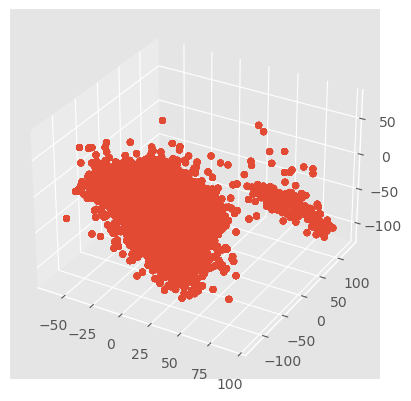

In [10]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2])

**d)** Read all sensor data and plot each dimension (there are 3 dimensions: x,y,z).

**Note:** Ignore the labels, create one plot for each dimensions containing all sensors.

In [11]:
Xsraw = [ pd.read_csv("data/activity_u1/u1_s{}_rechts.csv".format(i), header=1) for i in range(1,6)]
Xs = [ preprocess_raw(Xr)[0] for Xr in Xsraw ]  # only X values

In [70]:
print(Xs[0].shape)

(990400, 3)


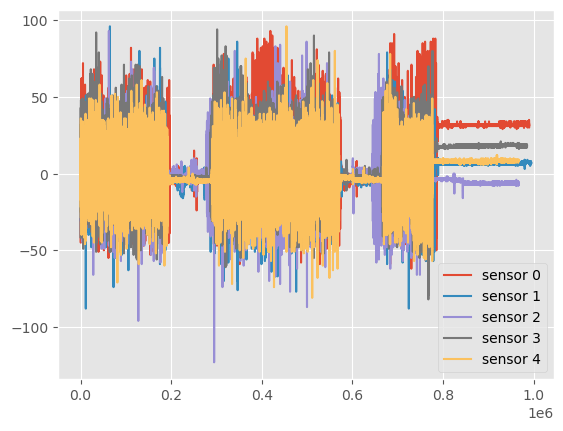

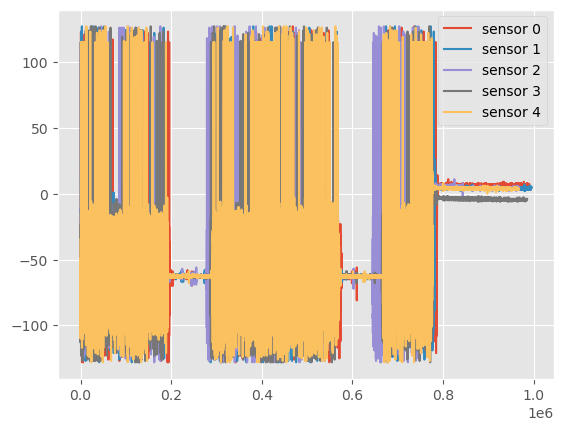

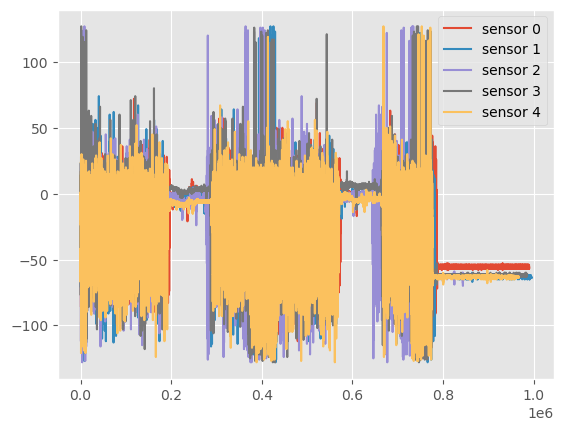

In [71]:
for dim in range(Xs[0].shape[1]):
    for sensor in range(len(Xs)):
        plt.plot(Xs[sensor][:,dim], label="sensor {}".format(sensor))
    #plt.scatter(Xs[i][:,0], Xs[i][:,1])
    plt.legend()
    plt.show()


**e)** Calculate the first 2 principal components using [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) for each sensor. Plot the matching principal components in individial plots.
What do you recognize?

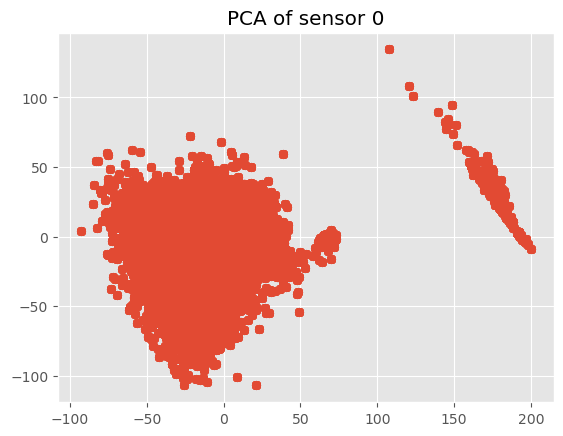

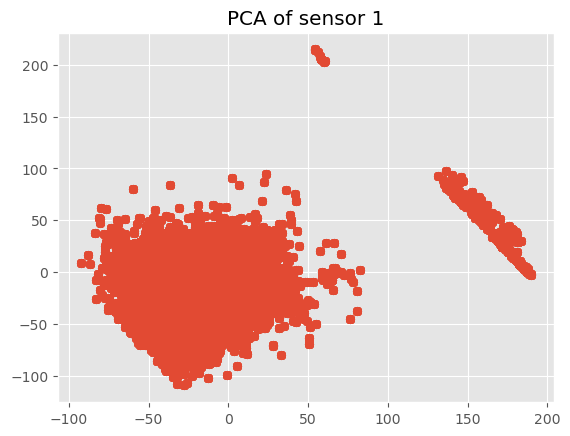

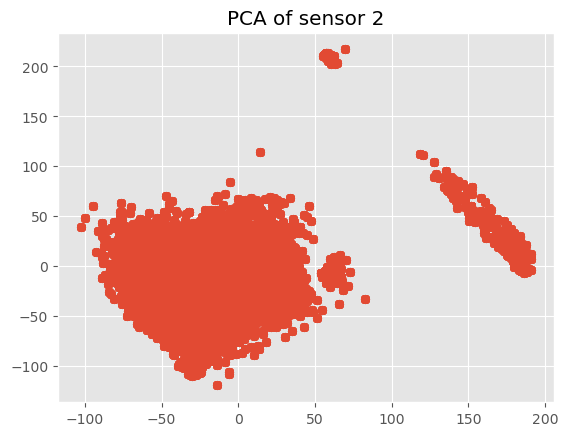

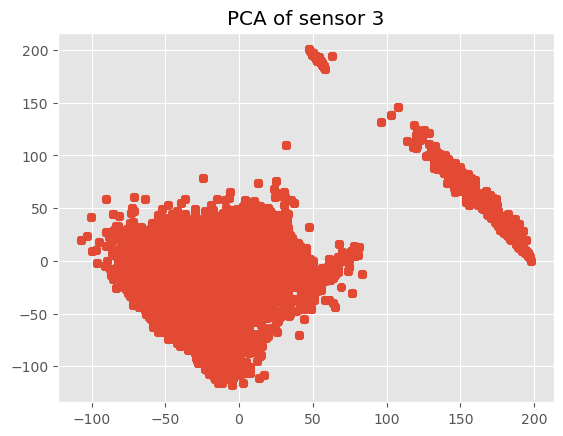

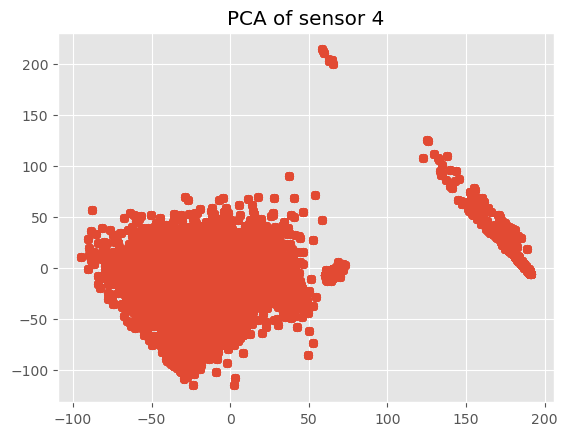

In [72]:
import sklearn
from sklearn.decomposition import PCA


pca = PCA(n_components=2)

for sensor in range(len(Xs)):
    Xpca = pca.fit_transform(Xs[sensor])
    plt.scatter(Xpca[:,0], Xpca[:,1])
    plt.title('PCA of sensor {}'.format(sensor))
    plt.show()


PCA sensor images:
- ranges change -> equal for all sensors
- similar patterns

### Task 3: Normalization and Standardization

**a)** Import the function "get_random_signal" from the "util" package.
Plot the returned date set using the functions "plot_equal" and "plot_range" from the same package.

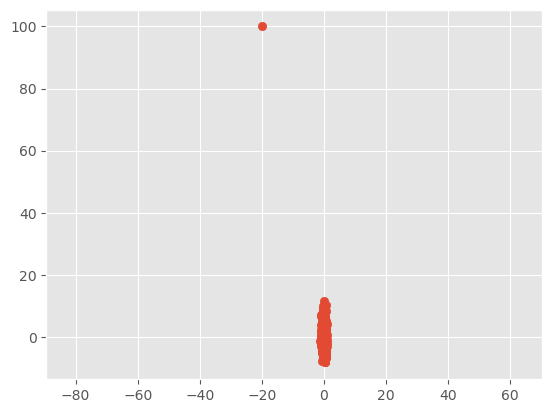

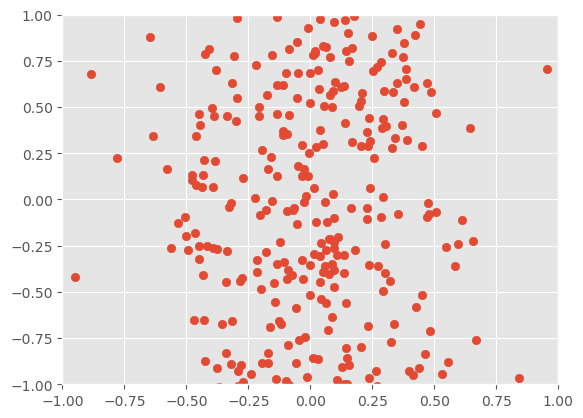

In [14]:
from util import get_random_signal
from util import plot_equal
from util import plot_range

Xnorm = get_random_signal()
plot_equal(Xnorm)
plot_range(Xnorm)

**b)** Implement a function to normalise and a function to standardise the data.
Plot the data in the range (-1,1) for x and y. Use the "apply_plot" function from the "util" package.

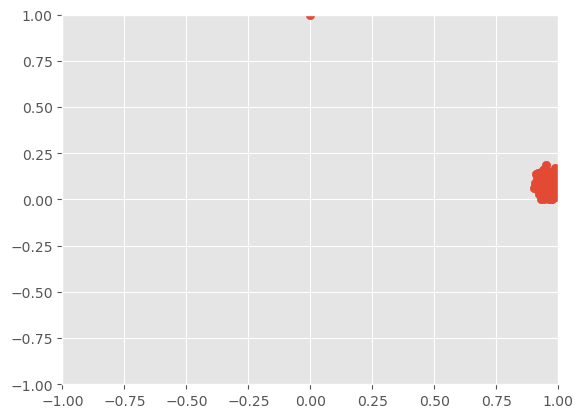

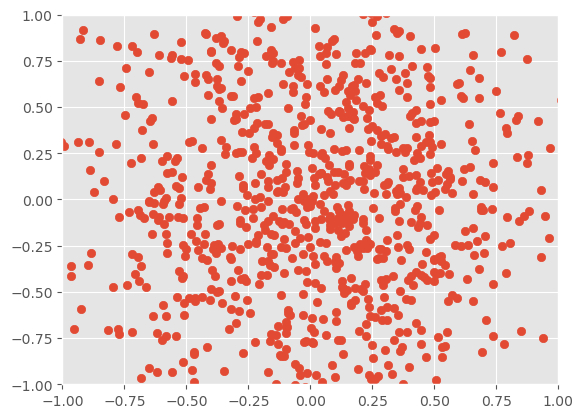

In [15]:
from util import apply_plot
def norm(X):
    a, b = np.min(X, axis=0), np.max(X, axis=0)
    return (X - a) / (b - a)
    
def ztrans(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    return (X - mu) / sigma

apply_plot(norm, Xnorm)
apply_plot(ztrans, Xnorm)

**c)** Remove all outliers and then normalise and standardize the data set.
Plot the resulting signal.

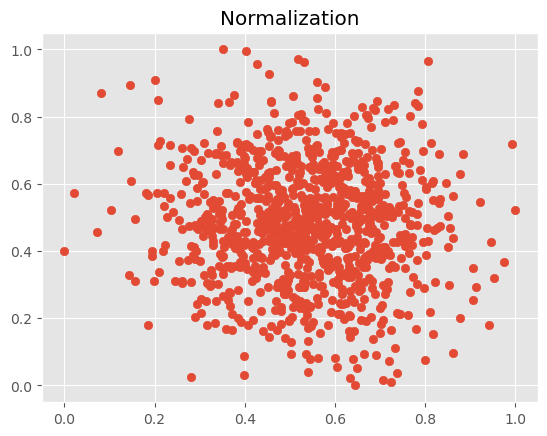

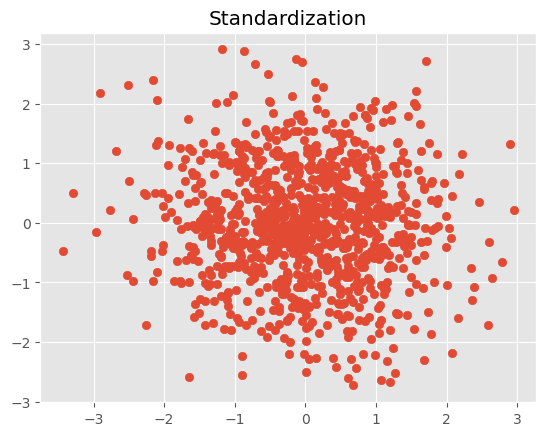

In [16]:
X_a = Xnorm.copy()
mu = np.mean(X_a, axis=0)
sigma = np.std(X_a, axis=0)

# replace outliers with NaN
for col in range(X_a.shape[1]):
    for idx in range(X_a.shape[0]):
        if (X_a[idx, col] > mu[col] + 2 * sigma[col]) or (X_a[idx, col] < mu[col] - 2 * sigma[col]):
            X_a[idx, col] = np.nan

# remove rows with NaN values
X_a = X_a[~np.isnan(X_a).any(axis=1)]

# apply normalization & z-transformation/standardization
X_a_norm = norm(X_a)
X_a_std = ztrans(X_a)

plt.scatter(X_a_norm[:,0], X_a_norm[:,1])
plt.title('Normalization')
plt.show()

plt.scatter(X_a_std[:,0], X_a_std[:,1])
plt.title('Standardization')
plt.show()


### Task 4: Discretization Quantization
**a)** Read the contents of "u1_s1_rechts.csv" and apply the following function.

In [18]:
def preprocess_raw(Xraw):
    """ Takes a pandas data frame with raw activity data,
    replaces its labels with numerical values and returns an ndarray 
    without a timestamp.
    
    Parameters:
    ===========
    Xraw - raw data frame
    
    Returns:
    ========
    X,y : ndarray with shape (n,3) [X, Y, Z] and labels
    """
    y = Xraw['Label'].astype('category').cat.codes.values
    X = Xraw[['X','Y','Z']].values
    return X,y

In [25]:
csv = pd.read_csv('data/activity_u1/u1_s1_rechts.csv', sep=',', header=1)
print(csv)
preprocessed = preprocess_raw(csv)
print(np.unique(preprocessed[1]))
print(preprocessed[0].shape)

          #Timestamp     X     Y     Z    Label
0       1.346755e+09   9.0 -64.0 -14.0  Walking
1       1.346755e+09   9.0 -64.0 -14.0  Walking
2       1.346755e+09   9.0 -64.0 -14.0  Walking
3       1.346755e+09   9.0 -64.0 -14.0  Walking
4       1.346755e+09   9.0 -64.0 -14.0  Walking
...              ...   ...   ...   ...      ...
990395  1.346757e+09  32.0   7.0 -56.0  Sitting
990396  1.346757e+09  32.0   7.0 -56.0  Sitting
990397  1.346757e+09  32.0   7.0 -56.0  Sitting
990398  1.346757e+09  32.0   7.0 -56.0  Sitting
990399  1.346757e+09  32.0   7.0 -56.0  Sitting

[990400 rows x 5 columns]
[0 1 2 3 4]
(990400, 3)


**b)** Reduce the size of the data set by 100 using the mean. 

**Note:** Consider the labels! Calculating the mean won't be helpful!

In [27]:
mean_signal = np.array([np.mean(preprocessed[0][i*100:(i+1)*100], axis=0) for i in range(len(preprocessed[0])//100)])
print(mean_signal.shape)
labels = np.array([np.median(preprocessed[1][i*100:(i+1)*100], axis=0) for i in range(len(preprocessed[1])//100)])

(9904, 3)


**c)** Plot the original and the sampled signal.

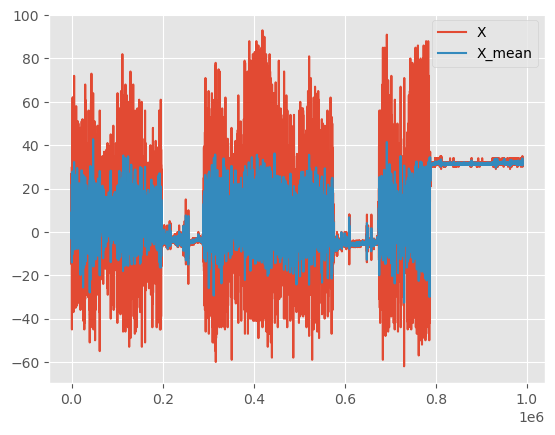

In [59]:
plt.figure()
plt.plot(preprocessed[0][:,0], label='X')
plt.plot(np.arange(0, len(preprocessed[0]), 100), mean_signal[:,0], label='X_mean')
#plt.xlim(0, 250)
plt.legend()

**d)** Quantise the signal with 32 levels. Implement the required function and plot the resulting signal.

Refer: 
[np.histogram](https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram.html)
[np.digitize](https://numpy.org/doc/stable/reference/generated/numpy.digitize.html)

In [53]:
def quantize(X, steps=32):
    quant = np.digitize(X, np.linspace(np.min(X), np.max(X), steps))
    return quant

9904
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31 32]


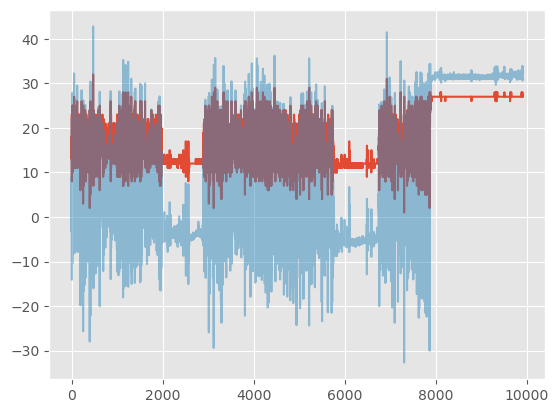

In [57]:
# Plot the quantized signal
print(len(mean_signal[:,0]))
quant = quantize(mean_signal[:,0])
print(np.unique(quant))
plt.figure()
#plt.scatter(np.arange(len(quant)), quant, s=1)
plt.plot(np.arange(len(quant)), quant, label='X_quant')
plt.plot(mean_signal[:,0], label='X_mean', alpha = 0.5)

**e)** Now, scatter the quantized signal again and use a color coding scheme for the labels.

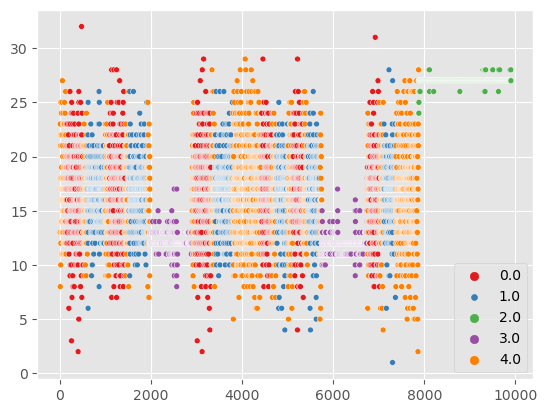

In [76]:
import seaborn as sns

#plt.figure()
#plt.scatter(np.arange(len(quant)), quant, s=2, c=labels, label=np.unique(labels))

sns.scatterplot(x=np.arange(len(quant)), y=quant, hue=labels, palette='Set1', legend='full', size=1)
plt.legend()

**f)** Save your quantized signal as "xquant.csv". 

In [78]:
df = pd.DataFrame({'x': np.arange(len(quant)), 'y': quant, 'label': labels})
df.to_csv('data/activity_u1/xquant.csv', sep=',', header=1)

### Task 5: Fourier Transform

In [79]:
import matplotlib.pyplot as plt
from util import get_signal
from scipy.stats import norm

**a)** Use the function **get_signal** to import the data with a sampling frequency of **100 Hz**.

It returns two variables x and y

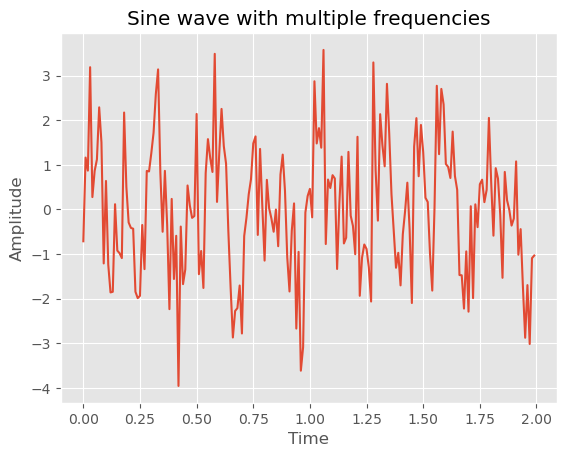

In [102]:
t, y = get_signal()

**b)** Use the [Fourier Transform](https://numpy.org/devdocs/reference/routines.fft.html) to provide the frequency domain representation of the original signal.

- Consider that the input **y** is a real-valued signal. Use the one-dimensional fourier transform for real input according to this assumption
- Since the input of the fourier-tranform is a time-domain signal, use numpy.abs() to display the amplitude spectrum
- Consider Normalization of the spectrum using the scaling factor $1/N$, $N$: Number of Samples
- Plot the frequency domain representation

1.0


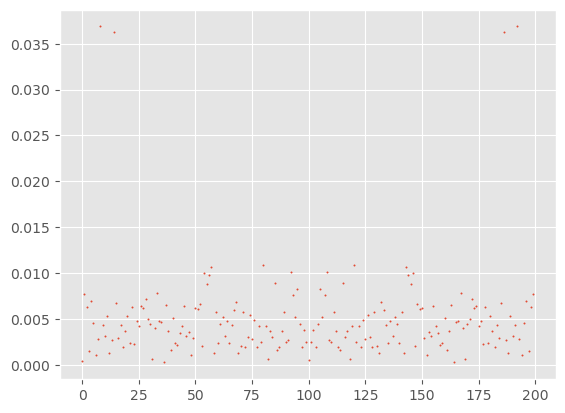

In [103]:
samplingFrequency = 100
frequencies = np.fft.fft(y)
normalized_freq = np.abs(frequencies)/np.abs(frequencies).sum()
print(normalized_freq.sum())
plt.scatter(np.arange(len(frequencies)), normalized_freq, s=0.8)


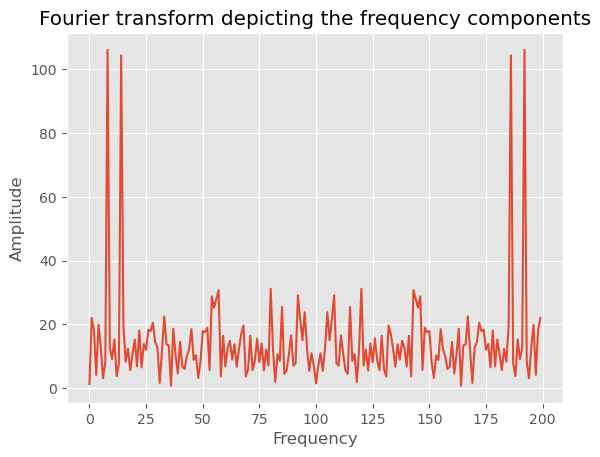

In [104]:
# Frequency domain representation
plt.figure()
plt.title('Fourier transform depicting the frequency components')
plt.plot(np.arange(len(frequencies)), np.abs(frequencies))

plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.show()
### ENDSOLUTION ###

**b)** Apply a low pass filter to the amplitude spectrum to reconstruct the signal and remove high frequency noise terms

True
10
(200,)
False


/opt/homebrew/anaconda3/envs/TSDM-env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


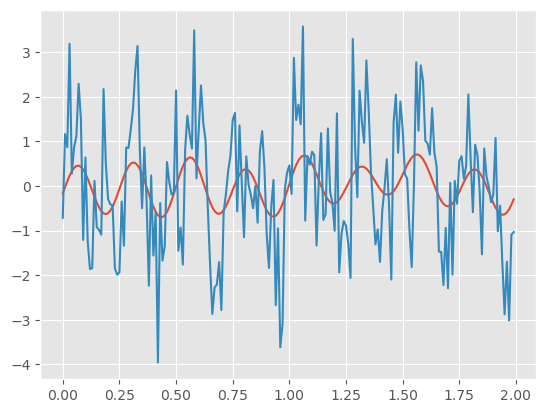

In [131]:
frequency_threshold = 100#len(frequencies)
#frequencies_subset = np.zeros(len(frequencies))
print(np.all(frequencies == np.fft.fft(y)))
#frequencies_subset[:frequency_threshold] = frequencies[:frequency_threshold]
frequencies_subset = np.array([frequencies[i] if i < frequency_threshold else 0 for i in range(len(frequencies))])
print(len(frequencies[:frequency_threshold]))
print(frequencies_subset.shape)
print(np.all(frequencies_subset == np.fft.fft(y)))
reconstructed_signal = np.fft.ifft(frequencies_subset)
plt.plot(t, reconstructed_signal)
plt.plot(t, y)
#plt.plot(t, y)
#plt.plot(t, np.fft.ifft(np.fft.fft(y)), alpha=0.5)

**c)** Apply the inverse Fourier Transform to reconstruct the Signal from the filtered amplitude spectrum

In [ ]:
####################
# Your Code Here   #
####################